# baseline을 기반으로 gradcam을 적용
- baseline을 기반으로 gradcamd을 적용하여 모델이 어디를 보고 있는지 확인

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [39]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision # PyTorch의 컴퓨터 비전 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈

import torch.nn.functional as F

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [4]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [5]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../datasets_fin/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 128
LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 32
num_workers = 0

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [6]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [7]:
# Dataset 정의
trn_dataset = ImageDataset(
    "../datasets_fin/train.csv",
    "../datasets_fin/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


In [8]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [9]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [10]:
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)

Loss: 1.6050: 100%|██████████| 50/50 [00:06<00:00,  7.24it/s]


train_loss: 1.7277
train_acc: 0.5554
train_f1: 0.4843
epoch: 0.0000



Loss: 0.9633: 100%|██████████| 50/50 [00:06<00:00,  8.21it/s]


train_loss: 0.4183
train_acc: 0.8701
train_f1: 0.8475
epoch: 1.0000



Loss: 1.5846: 100%|██████████| 50/50 [00:06<00:00,  8.09it/s]


train_loss: 0.2524
train_acc: 0.9210
train_f1: 0.9101
epoch: 2.0000



Loss: 2.4596: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


train_loss: 0.1848
train_acc: 0.9561
train_f1: 0.9537
epoch: 3.0000



Loss: 3.7536: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


train_loss: 0.1584
train_acc: 0.9739
train_f1: 0.9739
epoch: 4.0000



Loss: 3.8224: 100%|██████████| 50/50 [00:06<00:00,  8.01it/s]


train_loss: 0.1315
train_acc: 0.9809
train_f1: 0.9788
epoch: 5.0000



Loss: 0.6563: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


train_loss: 0.1099
train_acc: 0.9682
train_f1: 0.9657
epoch: 6.0000



Loss: 1.1012: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


train_loss: 0.0989
train_acc: 0.9777
train_f1: 0.9776
epoch: 7.0000



Loss: 0.5194: 100%|██████████| 50/50 [00:06<00:00,  7.77it/s]


train_loss: 0.0606
train_acc: 0.9834
train_f1: 0.9824
epoch: 8.0000



Loss: 0.2924: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s]

train_loss: 0.0267
train_acc: 0.9949
train_f1: 0.9946
epoch: 9.0000



## 6. test set으로 모델 확인

In [11]:
test_data = pd.read_csv('../datasets_fin/sample_submission.csv')
train_data = pd.read_csv('')

In [12]:
test_data

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [61]:
def get_test_item(idx):
    name, target = test_data.loc[idx,]
    # img = np.array(Image.open(os.path.join("../datasets_fin/test/", name)))
    # img = Image.open(os.path.join("../datasets_fin/test/", name)).rotate(270, PIL.Image.NEAREST, expand = 1).resize((128, 128))
    img = Image.open(os.path.join("../datasets_fin/test/", name)).resize((128, 128))

    # img = trn_transform(image=img)['image']
    return img, target, name

In [62]:
def get_train_item(idx):
    name, target = train_data.loc[idx,]
    # img = np.array(Image.open(os.path.join("../datasets_fin/train/", name)))
    # img = Image.open(os.path.join("../datasets_fin/train/", name)).rotate(270, PIL.Image.NEAREST, expand = 1).resize((128, 128))
    img = Image.open(os.path.join("../datasets_fin/train/", name)).resize((128, 128))

    # img = trn_transform(image=img)['image']
    return img, target, name

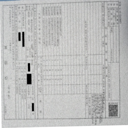

In [63]:
img, target, name = get_test_item(1)
img

In [67]:
target, name

(0, '00091bffdffd83de.jpg')

In [52]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [53]:
model.eval()
im_tensor = preprocess(img).unsqueeze(0).to(device) # 이미지를 batch 형태로 바꾸어 줌 (B x C x W x H)

In [54]:
class GradCam(nn.Module):
    def __init__(self, model, module, layer):
        super().__init__()
        self.model = model
        self.module = module
        self.layer = layer
        self.register_hooks()

    # register_forward_hook: Target Layer에 대해 forward pass를 통해 feature map을 얻음
    # register_backward_hook: Target Layer에 대해 backward pass를 통해 gradient를 계산
    def register_hooks(self):
        for modue_name, module in self.model._modules.items():
            if modue_name == self.module:
                for layer_name, module in module._modules.items():
                    if layer_name == self.layer:
                        if len(module._modules.items())!=0:
                            list(module._modules.items())[-1][1].register_forward_hook(self.forward_hook)
                            list(module._modules.items())[-1][1].register_backward_hook(self.backward_hook)
                            print(f'Target Layer is {modue_name}-{layer_name}, {list(module._modules.items())[-1][1]}')
                        else:
                            module.register_forward_hook(self.forward_hook)
                            module.register_backward_hook(self.backward_hook)
                            print(f'Target Layer is {modue_name}-{layer_name}')

    def forward(self, input, target_class):
        # outs.shape = [Batch, # of Class]
        outs = self.model(input)
        # outs.shape = [# of Class]
        outs = outs.squeeze()

        # target class option을 주지 않을 경우 가장 높은 score를 가진 class의 activation map을 시각화 합니다.
        if target_class is None:
            target_class = outs.argmax()

        # target class에 대해서 backward pass를 진행합니다
        outs[target_class].backward(retain_graph=True)

        # 각 Channel마다 Gradient들의 평균을 구합니다
        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)

        # Forward pass 결과와 Backward pass 결과로 구한 gradient(weight)를 곱해줍니다
        importance_weights = torch.sum(a_k * self.forward_result, dim=0)
        # ReLU 함수를 통해 음수를 제거해 주고, 최댓값으로 나누어 [0, 1]의 값을 가질 수 있도록 normalize 해줍니다
        activation_map = torch.relu(importance_weights) / torch.max(importance_weights)
        return activation_map, outs, outs.argmax()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])

Target Layer is layer4-1, ReLU(inplace=True)
torch.Size([7, 7]) 2


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


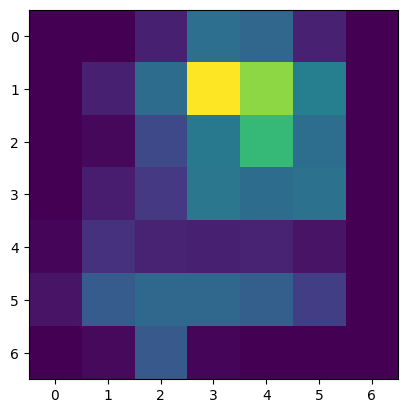

In [64]:
grad_cam = GradCam(model=model, module='layer4', layer='1')
mask, outs, cls_pred = grad_cam(im_tensor, None)

# activation map의 size를 확인합니다
print(mask.shape, cls_pred.item())
# activation map을 시각화 해봅니다
plt.imshow(mask.cpu().detach().squeeze().numpy())

In [40]:
def overlay_mask(img, mask):
    # 시각화를 위해 class activation map을 원본 이미지 크기로 변환시켜 줍니다.
    img_size = img.size
    mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), [img_size[1], img_size[0]], mode='bilinear')
    mask = mask.cpu().detach().squeeze().numpy()

    # 원본 이미지 위에 activation map을 그려 줍니다.
    plt.imshow(img)
    plt.imshow(mask, cmap='jet', alpha=0.5)

In [65]:
probabilities

tensor([0.0549, 0.0225, 0.5877, 0.0114, 0.0064, 0.0102, 0.0409, 0.0089, 0.0131,
        0.0093, 0.0149, 0.0222, 0.0194, 0.0062, 0.0095, 0.0118, 0.1508],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

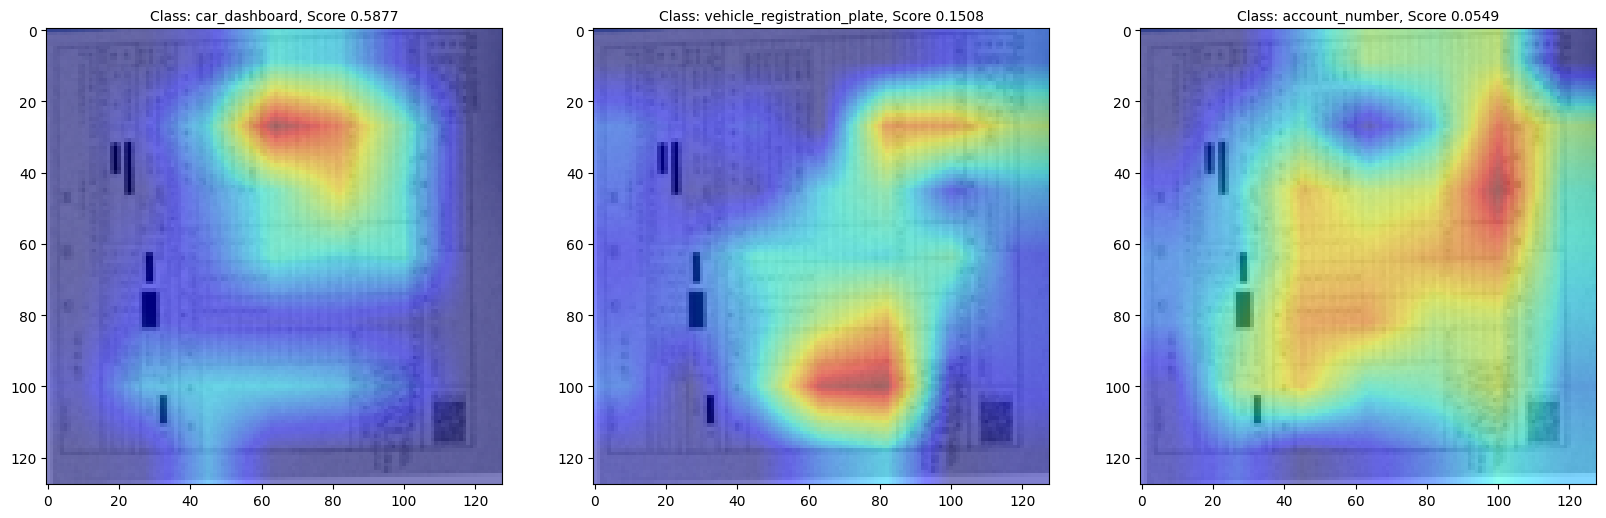

In [66]:
with open("imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

# softmax 결과 가장 높은 확률을 가지는 3개의 class 출력합니다
probabilities = torch.nn.functional.softmax(outs, dim=0)
top3_prob, top3_classes = torch.topk(probabilities, 3)

fig = plt.figure(figsize=(20, 20))
for i in range(top3_prob.size(0)):
    mask, _, _ = grad_cam(im_tensor,int(top3_classes[i].item()))

    a = fig.add_subplot(1, 3, i+1)
    overlay_mask(img, mask)
    a.set_title(f'Class: {classes[top3_classes[i]]}, Score {top3_prob[i].item():.4f}', fontsize=10)

In [ ]:
model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())